In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt


In [2]:
dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Scale to [-1, 1], Gaussian used in diffusion process is centred at 0
    ])
)

100%|██████████| 170M/170M [00:05<00:00, 29.1MB/s] 


In [3]:
# Forward Process

class Diffusion:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cuda"):
        self.timesteps = timesteps
        self.device = device
        
        # linear beta schedule (noise added)
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        
        # Pre-compute alphas
        self.alphas = 1.0 - self.betas # (signal kept)
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0) # alpha_bar_t = product(alpha)[from 0 to t] 
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0) # alpha_bar_t-1
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas) #

        # Pre-compute forward diffusion calculation terms
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        # Pre-compute posterior calculation terms
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

    def q_sample(self, x_start, t, noise):
        # Forward Diffusion Step

        # q(x_t | x_0) = N(x_t; sqrt(alpha_bar_t) * x_0, (1 - alpha_bar_t) * I) [eqn4]
        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def p_sample(self, model, x, t, t_index):
        # Reverse Diffusion Step

        beta_t = self._extract(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = self._extract(self.sqrt_recip_alphas, t, x.shape)
        
        # Predict noise
        # mu_theta(x_t, t) = (1 / sqrt(alpha_t)) * (x_t - (beta_t / sqrt(1 - alpha_bar_t)) * epsilon_theta(x_t, t)) [eqn11]
        model_mean = sqrt_recip_alphas_t * (
            x - beta_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
        )

        # Posterior Calculation
        # x_{t-1} = mu_theta(x_t) + sigma_t * z [eqn11*]
        if t_index == 0: # no noise at t=0 to return clean image (z=0)
            return model_mean
        else: # for t>1, we add noise (z ~ N(0, I))
            posterior_variance_t = self._extract(self.posterior_variance, t, x.shape)
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise

    def _extract(self, target, t, x_shape): # helper for selecting based on batch indices and broadcasting
        # target is full target array - we only want target elements corresponding to the random sample indices, t!
        # t is the indices of the random samples in the batch
        # x_shape is shape of the image tensor, that everything needs to be broadcasted to
        batch_size = t.shape[0]
        out = target.gather(-1, t)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

In [4]:
# Noise Prediction Model

class SinusoidalPositionEmbeddings(nn.Module):
    # Used to encode the 'diffusion time index' -> index itself could be used, but SPE is better (embedded indices are more 'distinct') -> like adding a minute or second hand to a clock
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    # U-net Components
    def __init__(self, in_channels, out_channels, time_emb_dim, up=False, down=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.norm1 = nn.GroupNorm(32, in_channels)
        self.norm2 = nn.GroupNorm(32, out_channels)
        self.act = nn.SiLU() # Sigmoid Linear Unit (like ReLU, without some of its downsides)
        
        if up:  # Upsampling (Decoder)
            self.conv1 = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(in_channels, out_channels, 3, padding=1)  # Better than ConvTranspose2d
            )
            self.transform = nn.Sequential( # Transform is needed to convert the +x component of Output = Convolution(x) + x we have with residual connections to ensure they are the same shape so we can add them
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(in_channels, out_channels, 1)
            )

        elif down: # Downsampling (Encoder)
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=2)
            self.transform = nn.Conv2d(in_channels, out_channels, 1, stride=2)

        else: # Processing (Bottleneck)
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
            self.transform = nn.Identity()

        # Kernel Size, Padding and Stride defined by input/output sizes: Output = 1 + (Input + 2*Padding - Kernel)/Stride

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

    def forward(self, x, t):
        # 1. First Layer (Norm -> Act -> Conv [potentially resize])
        h = self.norm1(x)
        h = self.act(h)
        h = self.conv1(h) # Main path resizing happens here now
        
        # 2. Add Time Embedding
        time_emb = self.time_mlp(self.act(t))
        time_emb = time_emb[:, :, None, None] # Broadcast
        h = h + time_emb
        
        # 3. Second Layer
        h = self.norm2(h)
        h = self.act(h)
        h = self.conv2(h)
        
        # 4. Residual Connection
        # Now h and self.transform(x) are guaranteed to be the same shape
        return h + self.transform(x)

class Attention(nn.Module):
    # Attention blocks are used for global context, CNN only fails at long range relations
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels) # Paper uses GroupNorm
        self.attention = nn.MultiheadAttention(embed_dim=channels, num_heads=num_heads, batch_first=True)

    def forward(self, x):
        B, C, H, W = x.shape
        # Flatten spatial dims
        x_flat = x.view(B, C, -1).permute(0, 2, 1)
        
        # Apply normalization before attention
        x_norm = self.norm(x).view(B, C, -1).permute(0, 2, 1)
        
        # Self-Attention
        attn_output, _ = self.attention(x_norm, x_norm, x_norm) # x_norm for all, as this is SELF attention
        
        # Add residual connection + Reshape back
        x_out = x_flat + attn_output

        return x_out.permute(0, 2, 1).view(B, C, H, W) # return unflattened x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding MLP
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsampling Path
        self.downs = nn.ModuleList([
            Block(down_channels[i], down_channels[i+1], time_emb_dim, down=True) 
            for i in range(len(down_channels)-1)
        ])
        
        # Attention Blocks
        self.attentions = nn.ModuleList([
            nn.Identity(),
            nn.Identity(),
            Attention(down_channels[3]),
            Attention(down_channels[4]),
        ])

        # Bottleneck
        self.bottleneck1 = Block(down_channels[-1], down_channels[-1], time_emb_dim)
        self.bottleneck_attn = Attention(down_channels[-1])
        self.bottleneck2 = Block(down_channels[-1], down_channels[-1], time_emb_dim)

        # Upsampling Path
        self.ups = nn.ModuleList([
            Block(up_channels[i] * 2, up_channels[i+1], time_emb_dim, up=True) 
            for i in range(len(up_channels)-1)
        ])
        
        # Final output
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # 1. Embed Time
        t = self.time_mlp(timestep)
        
        # 2. Initial Conv
        x = self.conv0(x)
        
        # 3. Downsampling Loop
        residuals = []
        for down, attn in zip(self.downs, self.attentions):
            x = down(x, t)
            x = attn(x)
            residuals.append(x)
            
        # 4. Bottleneck
        x = self.bottleneck1(x, t)
        x = self.bottleneck_attn(x)
        x = self.bottleneck2(x, t)
        
        # 5. Upsampling Loop
        for up, residual in zip(self.ups, reversed(residuals)):
            x = torch.cat((x, residual), dim=1)
            x = up(x, t)
            
        return self.output(x)

In [5]:
# Reverse Process

def train_ddpm(dataloader, model, diffusion, epochs=5, device="cuda"):

    # Shift to 'training mode' -> dropout is enabled, normalisation layer statistics are dynamic
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4) 
    mse = nn.MSELoss() # Minimising SE == Maximising Likelihood (of Gaussian distribution, which the noise follows)

    for epoch in range(epochs):
        for step, (images, _) in enumerate(dataloader):
            optimizer.zero_grad() # reset gradients
            
            batch_size = images.shape[0]
            images = images.to(device) # shifts images from CPU to device (i.e. GPU)

            # Sample random timesteps t for the batch
            t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device).long()

            # Sample random noise epsilon
            noise = torch.randn_like(images)

            # Create noisy images at specific timesteps (from batch) x_t
            x_t = diffusion.q_sample(images, t, noise)

            # Predict the noise
            predicted_noise = model(x_t, t)

            # Calculate Loss
            loss = mse(noise, predicted_noise)

            loss.backward()
            
            # Clip the norm of the gradient to 1 for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()

            if step % 100 == 0:
                print(f"Epoch {epoch} | Step {step} | Loss: {loss.item():.4f}")

In [6]:
@torch.no_grad() # Stops gradients being saved (during inference)

def sample_ddpm(model, diffusion, image_size, batch_size=1, device="cuda"):

    # Shift to 'inference mode' -> dropout is disabled, normalisation layers are fixed
    model.eval()

    # Pure noise
    img = torch.randn((batch_size, 3, image_size, image_size), device=device)

    # Iteratively denoise until theoretically clean
    for i in reversed(range(0, diffusion.timesteps)):
        t = torch.full((batch_size,), i, device=device, dtype=torch.long) # vectorised time step
        img = diffusion.p_sample(model, img, t, i) # vectorised computation of the (1-step) denoised image
        
    # Clamp to [-1, 1] range -> ensure we don't overflow due to random noise
    img = torch.clamp(img, -1, 1)
    
    # Convert to [0, 255] for display
    img = (img + 1) / 2 * 255
    return img.cpu().numpy().astype(np.uint8)

In [7]:
device = "cuda" # "mps" "cuda", "cpu"
print(f"Using device: {device}")

# Hyperparameters
batch_size = 64
timesteps = 1000
epochs = 50 # 10 to test, 50 for ok results, 200 for reasonable results, 800 for paper replication

# Load data
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    drop_last=True
)

# Initiate model and diffusion classes
model = UNet().to(device)
diffusion = Diffusion(timesteps=timesteps, device=device)

print("Starting Training...")
train_ddpm(dataloader, model, diffusion, epochs=epochs, device=device)

Using device: cuda
Starting Training...
Epoch 0 | Step 0 | Loss: 1.1371
Epoch 0 | Step 100 | Loss: 0.2813
Epoch 0 | Step 200 | Loss: 0.1543
Epoch 0 | Step 300 | Loss: 0.0951
Epoch 0 | Step 400 | Loss: 0.0792
Epoch 0 | Step 500 | Loss: 0.0520
Epoch 0 | Step 600 | Loss: 0.0688
Epoch 0 | Step 700 | Loss: 0.0572
Epoch 1 | Step 0 | Loss: 0.0436
Epoch 1 | Step 100 | Loss: 0.0603
Epoch 1 | Step 200 | Loss: 0.0666
Epoch 1 | Step 300 | Loss: 0.0709
Epoch 1 | Step 400 | Loss: 0.0569
Epoch 1 | Step 500 | Loss: 0.0497
Epoch 1 | Step 600 | Loss: 0.0410
Epoch 1 | Step 700 | Loss: 0.0358
Epoch 2 | Step 0 | Loss: 0.0434
Epoch 2 | Step 100 | Loss: 0.0460
Epoch 2 | Step 200 | Loss: 0.0380
Epoch 2 | Step 300 | Loss: 0.0262
Epoch 2 | Step 400 | Loss: 0.0553
Epoch 2 | Step 500 | Loss: 0.0731
Epoch 2 | Step 600 | Loss: 0.0385
Epoch 2 | Step 700 | Loss: 0.0418
Epoch 3 | Step 0 | Loss: 0.0523
Epoch 3 | Step 100 | Loss: 0.0352
Epoch 3 | Step 200 | Loss: 0.0741
Epoch 3 | Step 300 | Loss: 0.0357
Epoch 3 | Step 4

Generating images...


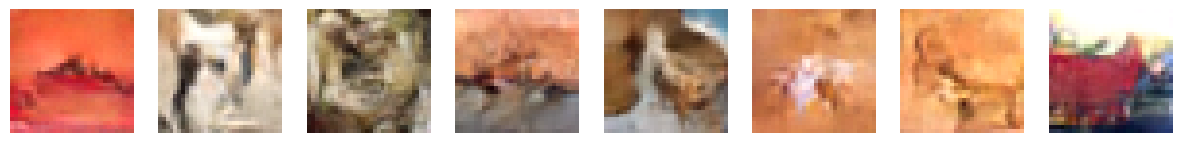

In [9]:
# Generate images and display

print("Generating images...")
generated_images = sample_ddpm(model, diffusion, image_size=32, batch_size=8, device=device) # generate 8 images

fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i, img in enumerate(generated_images):
    # Convert (C, H, W) -> (H, W, C) for Matplotlib
    img_display = np.transpose(img, (1, 2, 0))
    axes[i].imshow(img_display)
    axes[i].axis('off')
plt.show()